# TESS Analyis

<font color='gray'> Author: Pedro Mas Buitrago, Centro de Astrobiología (CAB) </font>

<font color='gray'> Last updated -- 20/september/2024 </font>

<font color='gray'> pmas@cab.inta-csic.es </font>

<font color='gray'>https://pedromasb.github.io</font>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.io import fits
from astropy.table import Table
import lightkurve as lk
from astropy.timeseries import LombScargle
from PyAstronomy.pyasl import foldAt

import warnings
warnings.filterwarnings('ignore')

# Flares

In [3]:
path = 'data/TESS'
df_jp0903 = Table.read(f'{path}/tess2020020091053-s0021-0000000166597074-0167-s_lc.fits').to_pandas()
df_jp0903_gq = df_jp0903[df_jp0903['QUALITY'] == 0]

df_44 = Table.read(f'{path}/tess2021284114741-s0044-0000000461654150-0215-s_lc.fits').to_pandas()
df_44_gq = df_44[df_44['QUALITY'] == 0]

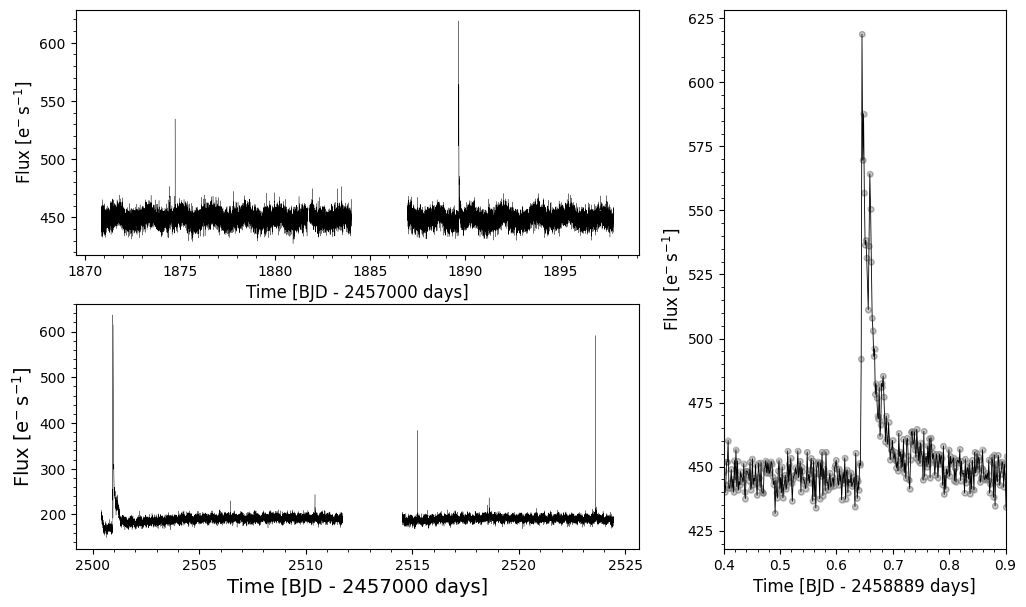

In [23]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[1,0.5])

ax1 = plt.subplot(gs[0,0]) 

ax1.set_xlabel('Time [BJD - 2457000 days]',fontsize=12)
ax1.set_ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}}$]',fontsize=12)

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.patch.set_alpha(0.01)

ax1.plot(df_jp0903_gq[df_jp0903_gq['TIME'] < 1885]['TIME'],df_jp0903_gq[df_jp0903_gq['TIME'] < 1885]['PDCSAP_FLUX'],color='black',lw=0.2)
ax1.plot(df_jp0903_gq[df_jp0903_gq['TIME'] > 1885]['TIME'],df_jp0903_gq[df_jp0903_gq['TIME'] > 1885]['PDCSAP_FLUX'],color='black',lw=0.2)

ax2 = plt.subplot(gs[1,0]) 

ax2.set_xlabel('Time [BJD - 2457000 days]',fontsize=14)
ax2.set_ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}}$]',fontsize=14)

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.plot(df_44_gq[df_44_gq['TIME']<2513]['TIME'],df_44_gq[df_44_gq['TIME']<2513]['PDCSAP_FLUX'],color='black',lw=0.2)
ax2.plot(df_44_gq[df_44_gq['TIME']>2513]['TIME'],df_44_gq[df_44_gq['TIME']>2513]['PDCSAP_FLUX'],color='black',lw=0.2)

ax3 = plt.subplot(gs[:,1])
ax3.set_xlim(left=1889.4,right=1889.9)

ax3.set_xlabel('Time [BJD - 2458889 days]',fontsize=12)
ax3.set_ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}}$]',fontsize=12)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax3.scatter(df_jp0903_gq['TIME'],df_jp0903_gq['PDCSAP_FLUX'],s=15,color='grey',alpha=0.4)
ax3.scatter(df_jp0903_gq['TIME'],df_jp0903_gq['PDCSAP_FLUX'],s=15,ec='grey',fc='none',alpha=0.7,lw=0.5)
ax3.plot(df_jp0903_gq['TIME'],df_jp0903_gq['PDCSAP_FLUX'],color='black',lw=0.6)

ax3.set_xticklabels([.4,.5,.6,.7,.8,.9])

plt.show()

# Rotation Periods

In [34]:
def periodogram_simple(t, period, y, yerr):

    phase0 = foldAt(t, period, T0=t.values[0])
    phase1 = phase0-1    
    
    df_fold = pd.DataFrame({'phase0':phase0,
                            'phase1':phase1,
                            'y':y,
                            'yerr':yerr}
            )
    
    df_fold = df_fold.sort_values(by='phase0')
    
    df_fold_final = pd.DataFrame({'phase':np.hstack((df_fold['phase0'].values,df_fold['phase1'].values)),
             'y':np.hstack((df_fold['y'].values,df_fold['y'].values)),
             'yerr':np.hstack((df_fold['yerr'].values,df_fold['yerr'].values))}
            )
    
    return df_fold_final

In [30]:
def clean_outliers(df, flux_name, IQ_factor):
    y=df[flux_name]
    Q1 = y.quantile(0.25)

    Q3 = y.quantile(0.75)

    IQR = Q3 - Q1
    
    df=df[(y < (Q1 - IQ_factor * IQR)) |(y > (Q3 + IQ_factor * IQR))]
    return (df)

In [35]:
def create_binning_nbins(df,nbins):
    
    nbin = 1
    npts = 1
    nbin_list = []
    pts_per_bin = len(df)/nbins

    for i in range(len(df)):
        
        if npts <= pts_per_bin:
            
            nbin = nbin
            nbin_list.append(nbin)
            
            npts += 1
        
        else:
            
            nbin += 1
            
            nbin_list.append(nbin)
            
            npts = 1
            
    return nbin_list

## J-PLUS0807

In [46]:
flc20 = lk.io.tess.read_tess_lightcurve(f'data/TESS/tess2019357164649-s0020-0000000461654150-0165-s_lc.fits')
flc44 = lk.io.tess.read_tess_lightcurve(f'data/TESS/tess2021284114741-s0044-0000000461654150-0215-s_lc.fits')
flc45 = lk.io.tess.read_tess_lightcurve(f'data/TESS/tess2021310001228-s0045-0000000461654150-0216-s_lc.fits')
flc46 = lk.io.tess.read_tess_lightcurve(f'data/TESS/tess2021336043614-s0046-0000000461654150-0217-s_lc.fits')
flc47 = lk.io.tess.read_tess_lightcurve(f'data/TESS/tess2021364111932-s0047-0000000461654150-0218-s_lc.fits')

lc_col = lk.LightCurveCollection([flc20,flc44,flc45,flc46,flc47])
lc_st = lc_col.stitch()
lc_st_df = lc_st.to_pandas()

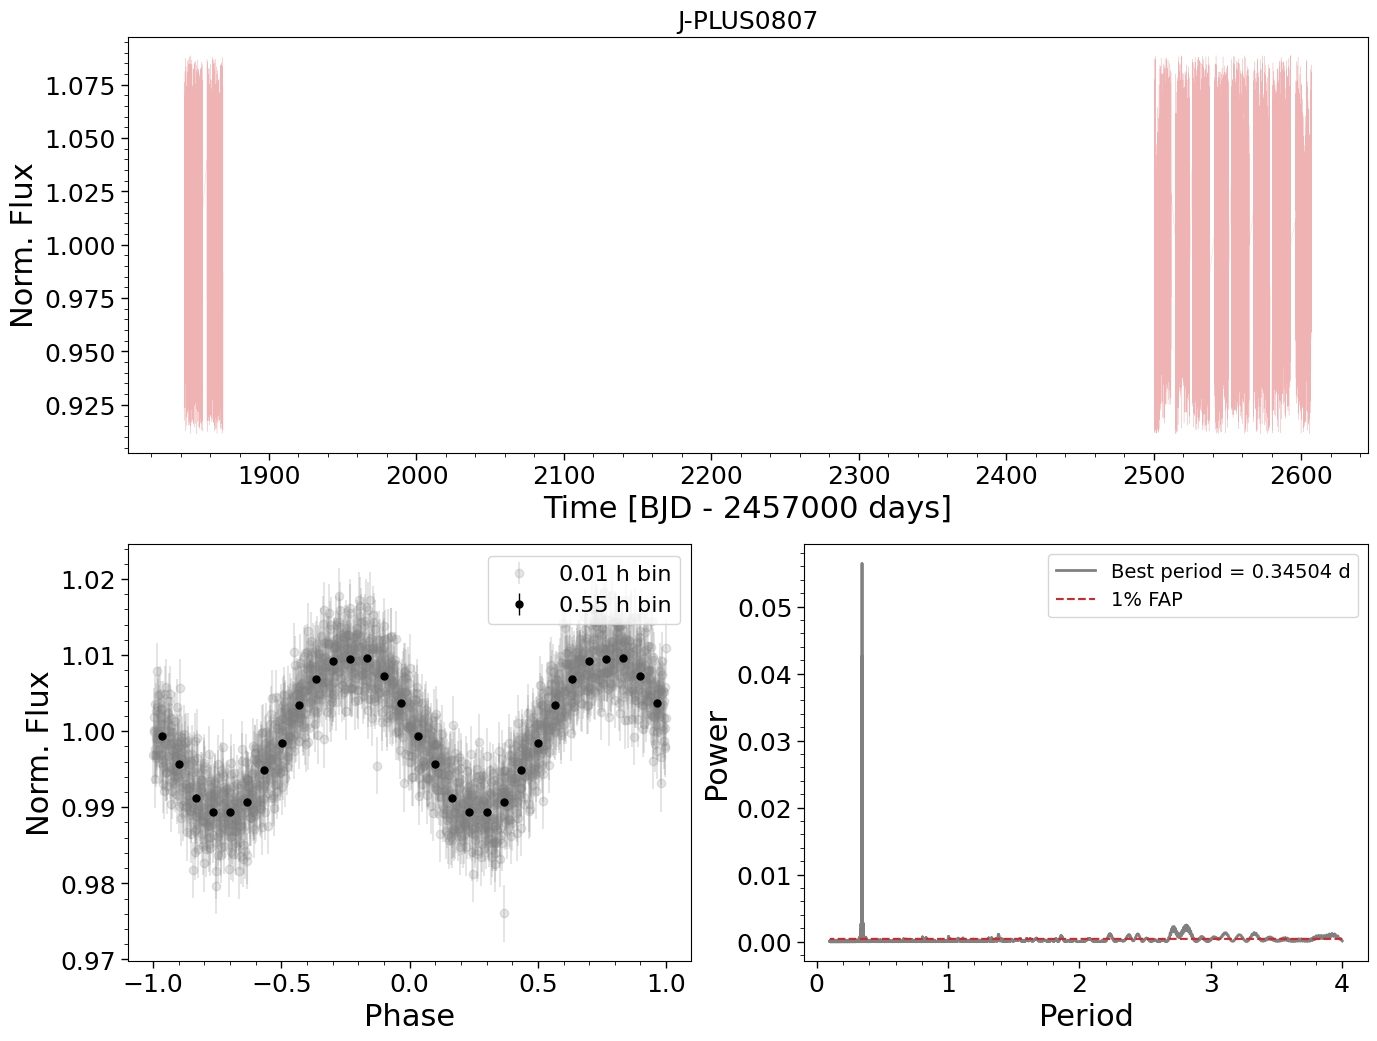

In [57]:
lc_df = pd.DataFrame(lc_st_df[['flux','flux_err','quality']].values,columns=['PDCSAP_FLUX','PDCSAP_FLUX_ERR', 'QUALITY'])
lc_df['TIME'] = lc_st_df.index.values
lc_df = lc_df.dropna(axis=0)    

lc_df['PDCSAP_FLUX_norm'] = lc_df['PDCSAP_FLUX']/np.nanmedian(lc_df['PDCSAP_FLUX'])
lc_df = lc_df.drop(clean_outliers(lc_df,'PDCSAP_FLUX_norm', IQ_factor=1.5).index)

time = lc_df['TIME']
flux = lc_df['PDCSAP_FLUX']
flux_norm = lc_df['PDCSAP_FLUX_norm']
flux_err = lc_df['PDCSAP_FLUX_ERR']

ls = LombScargle(time, flux, flux_err, nterms=1, fit_mean=True)

Pmin, Pmax = 0.1, 4
frequencies, powers = ls.autopower(minimum_frequency=1./Pmax, maximum_frequency=1./Pmin)
periods = 1 / frequencies

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)

periods_faps = periods[powers > faps[1]]
powers_faps = powers[powers > faps[1]]

df_pf = pd.DataFrame({'period':periods,'power':powers,'frequency':frequencies}).sort_values(by='power',ascending=False)
chosen_period = df_pf['period'].values[0]

df_final = periodogram_simple(t=time, y=flux, yerr=flux_err,
                                    period=chosen_period)

bins_fold = create_binning_nbins(df_final,nbins=30)
df_final['bin_nbins'] = bins_fold

tbin_fold = []
wavg_fold = []
unc_fold = []

for k in df_final['bin_nbins'].unique():
    
    data = df_final[df_final['bin_nbins'] == k]    
    wavg = np.average(data['y'], weights=1/(data['yerr'])**2)
    unc = np.sqrt(np.sum(data['yerr']**2)) / len(data)
    tbin = np.mean(data['phase'])

    wavg_fold.append(wavg/np.nanmedian(lc_df['PDCSAP_FLUX']))
    unc_fold.append(unc/np.nanmedian(lc_df['PDCSAP_FLUX']))
    tbin_fold.append(tbin)

bins_fold2 = create_binning_nbins(df_final,nbins=2000)
df_final['bin_nbins2'] = bins_fold2

tbin_fold2 = []
wavg_fold2 = []
unc_fold2 = []

for k in df_final['bin_nbins2'].unique():
    
    data = df_final[df_final['bin_nbins2'] == k]    
    wavg = np.average(data['y'], weights=1/(data['yerr'])**2)
    unc = np.sqrt(np.sum(data['yerr']**2)) / len(data)
    tbin = np.mean(data['phase'])

    wavg_fold2.append(wavg/np.nanmedian(lc_df['PDCSAP_FLUX']))
    unc_fold2.append(unc/np.nanmedian(lc_df['PDCSAP_FLUX']))
    tbin_fold2.append(tbin)

# -------------------------------------------------------------------------------------
            
fig = plt.figure(figsize=(16,12))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1],height_ratios=[1,1])

### Lightcurve general para entender mejor los foldings:

ax1 = fig.add_subplot(gs[0, :])

ax1.tick_params(axis='both', which='major', labelsize=18,width=1,length=5)
ax1.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylabel('Norm. Flux', fontsize=22)
ax1.set_xlabel('Time [BJD - 2457000 days]', fontsize=22)

ax1.plot(lc_df[lc_df['TIME']<1885]['TIME'].values, lc_df[lc_df['TIME']<1885]['PDCSAP_FLUX_norm'].values, lw=0.2,color='tab:red',alpha=0.35)
ax1.plot(lc_df[lc_df['TIME']>1885]['TIME'].values, lc_df[lc_df['TIME']>1885]['PDCSAP_FLUX_norm'].values, lw=0.2,color='tab:red',alpha=0.35)

ax1.set_title('J-PLUS0807',fontsize=18)

# -------------------------------------------------------------------------------------

ax2 = fig.add_subplot(gs[1, 0])

ax2.tick_params(axis='both', which='major', labelsize=18,width=1,length=5)
ax2.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.set_xlabel('Phase', fontsize=22)
ax2.set_ylabel('Norm. Flux', fontsize=22)

ax2.errorbar(tbin_fold2,wavg_fold2, yerr=unc_fold2,ms=6,fmt='o',capsize=0,lw=1.5, color='grey',alpha=0.2,label='0.01 h bin')
ax2.errorbar(tbin_fold,wavg_fold, yerr=unc_fold,ms=5,fmt='o',capsize=0,lw=1, color='black',label='0.55 h bin')
ax2.legend(fontsize=16,loc='upper right')

# -------------------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 1])

ax3.tick_params(axis='both', which='major', labelsize=18,width=1,length=5)
ax3.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax3.set_ylabel('Power', fontsize=22)
ax3.set_xlabel('Period', fontsize=22)
ax3.plot(periods, powers, linewidth=2.0, color='grey',label=f'Best period = {np.around(chosen_period, decimals=5)} d')
ax3.plot(periods,np.ones(len(periods))*faps[1],color='tab:red',ls='--',label='1% FAP')

ax3.legend(fontsize=14,loc='upper right')

plt.subplots_adjust(wspace=0.2, hspace=0.22)
plt.savefig(f'JPLUS0807_period_all_sectors.pdf',format='pdf',bbox_inches="tight")

plt.show()

## J-PLUS0903

In [27]:
flc = lk.io.tess.read_tess_lightcurve('data/TESS/tess2020020091053-s0021-0000000166597074-0167-s_lc.fits')
lc_df_ = flc.to_pandas()

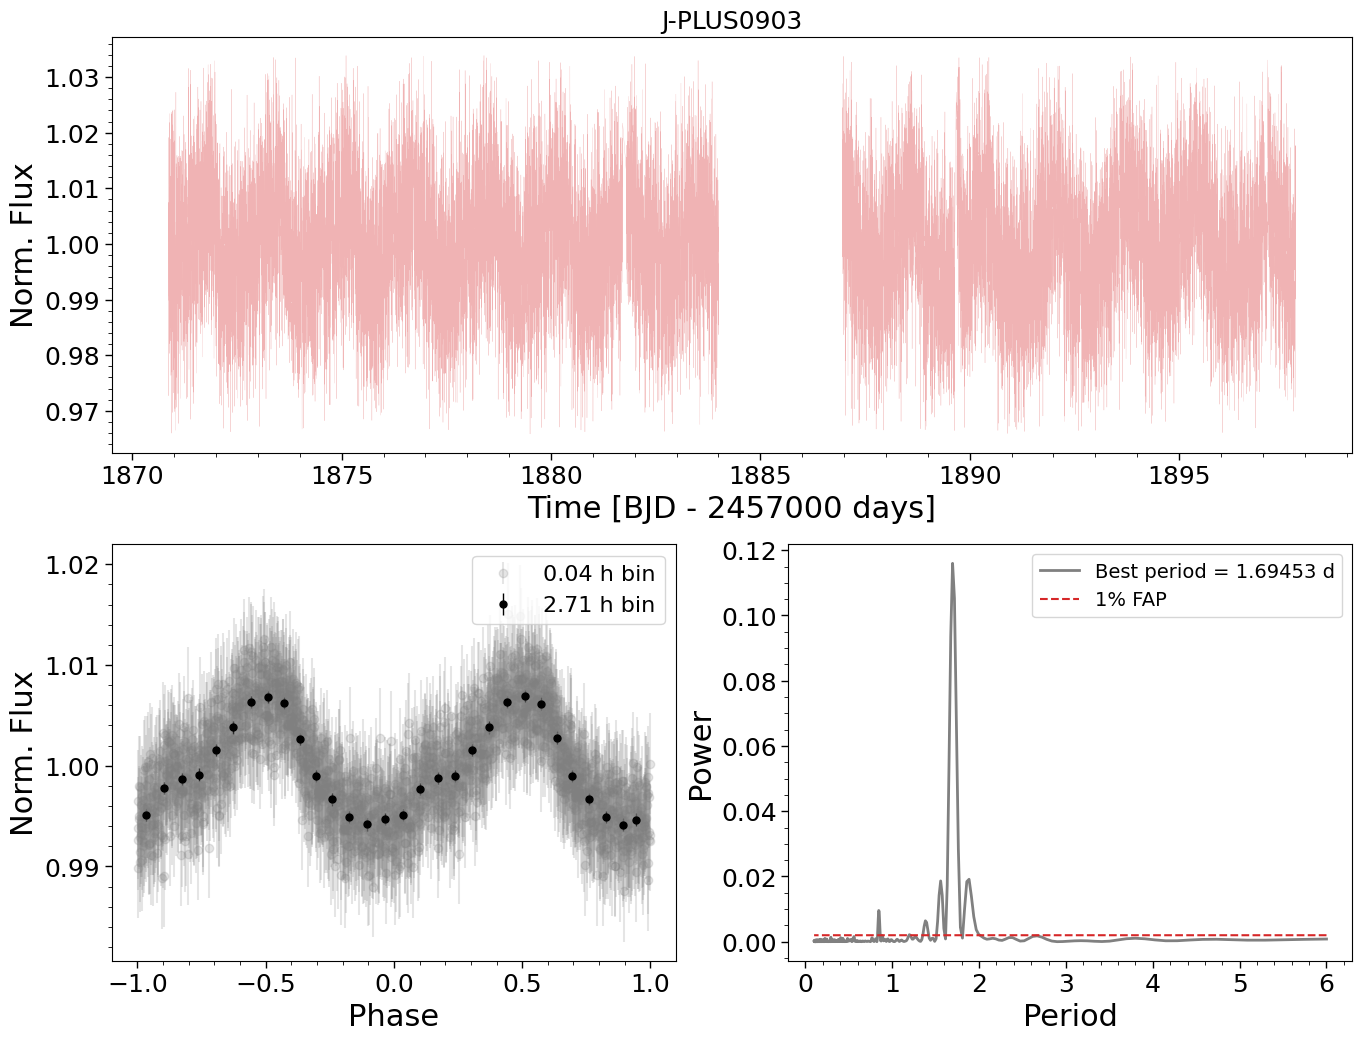

In [58]:
lc_df = pd.DataFrame(lc_df_[['flux','flux_err','quality']].values,columns=['PDCSAP_FLUX','PDCSAP_FLUX_ERR', 'QUALITY'])
lc_df['TIME'] = lc_df_.index.values
lc_df = lc_df.dropna(axis=0)   
lc_df['PDCSAP_FLUX_norm'] = lc_df['PDCSAP_FLUX']/np.nanmedian(lc_df['PDCSAP_FLUX'])
lc_df = lc_df.drop(clean_outliers(lc_df,'PDCSAP_FLUX_norm', IQ_factor=1.5).index)

time = lc_df['TIME']
flux = lc_df['PDCSAP_FLUX']
flux_err = lc_df['PDCSAP_FLUX_ERR']

ls = LombScargle(time, flux, flux_err, nterms=1, fit_mean=True)

Pmin, Pmax = 0.1, 6
frequencies, powers = ls.autopower(minimum_frequency=1./Pmax, maximum_frequency=1./Pmin)
periods = 1 / frequencies

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)

periods_faps = periods[powers > faps[1]]
powers_faps = powers[powers > faps[1]]

df_pf = pd.DataFrame({'period':periods,'power':powers,'frequency':frequencies}).sort_values(by='power',ascending=False)
chosen_period = df_pf['period'].values[0]

df_final = periodogram_simple(t=time, y=flux, yerr=flux_err,
                                    period=chosen_period)

bins_fold = create_binning_nbins(df_final,nbins=30)
df_final['bin_nbins'] = bins_fold

tbin_fold = []
wavg_fold = []
unc_fold = []

for k in df_final['bin_nbins'].unique():
    
    data = df_final[df_final['bin_nbins'] == k]    
    wavg = np.average(data['y'], weights=1/(data['yerr'])**2)
    unc = np.sqrt(np.sum(data['yerr']**2)) / len(data)
    tbin = np.mean(data['phase'])

    wavg_fold.append(wavg/np.nanmedian(lc_df['PDCSAP_FLUX']))
    unc_fold.append(unc/np.nanmedian(lc_df['PDCSAP_FLUX']))
    tbin_fold.append(tbin)

bins_fold2 = create_binning_nbins(df_final,nbins=2000)
df_final['bin_nbins2'] = bins_fold2

tbin_fold2 = []
wavg_fold2 = []
unc_fold2 = []

for k in df_final['bin_nbins2'].unique():
    
    data = df_final[df_final['bin_nbins2'] == k]    
    wavg = np.average(data['y'], weights=1/(data['yerr'])**2)
    unc = np.sqrt(np.sum(data['yerr']**2)) / len(data)
    tbin = np.mean(data['phase'])

    wavg_fold2.append(wavg/np.nanmedian(lc_df['PDCSAP_FLUX']))
    unc_fold2.append(unc/np.nanmedian(lc_df['PDCSAP_FLUX']))
    tbin_fold2.append(tbin)
# -------------------------------------------------------------------------------------
            
fig = plt.figure(figsize=(16,12))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1],height_ratios=[1,1])

ax1 = fig.add_subplot(gs[0, :])

ax1.tick_params(axis='both', which='major', labelsize=18,width=1,length=5)
ax1.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylabel('Norm. Flux', fontsize=22)
ax1.set_xlabel('Time [BJD - 2457000 days]', fontsize=22)

ax1.plot(lc_df[lc_df['TIME']<1885]['TIME'].values, lc_df[lc_df['TIME']<1885]['PDCSAP_FLUX_norm'].values, lw=0.2,color='tab:red',alpha=0.35)
ax1.plot(lc_df[lc_df['TIME']>1885]['TIME'].values, lc_df[lc_df['TIME']>1885]['PDCSAP_FLUX_norm'].values, lw=0.2,color='tab:red',alpha=0.35)

ax1.set_title('J-PLUS0903',fontsize=18)

# -------------------------------------------------------------------------------------

ax2 = fig.add_subplot(gs[1, 0])

ax2.tick_params(axis='both', which='major', labelsize=18,width=1,length=5)
ax2.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.set_xlabel('Phase', fontsize=22)
ax2.set_ylabel('Norm. Flux', fontsize=22)

ax2.errorbar(tbin_fold2,wavg_fold2, yerr=unc_fold2,ms=6,fmt='o',capsize=0,lw=1.5, color='grey',alpha=0.2,label='0.04 h bin')
ax2.errorbar(tbin_fold,wavg_fold, yerr=unc_fold,ms=5,fmt='o',capsize=0,lw=1, color='black',label='2.71 h bin')
ax2.legend(fontsize=16,loc='upper right')

# -------------------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 1])

# ax3.set_xlim(0, 6)
ax3.tick_params(axis='both', which='major', labelsize=18,width=1,length=5)
ax3.tick_params(axis='both', which='minor', labelsize=12, length=3)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax3.set_ylabel('Power', fontsize=22)
ax3.set_xlabel('Period', fontsize=22)
ax3.plot(periods, powers, linewidth=2.0, color='grey',label=f'Best period = {np.around(chosen_period, decimals=5)} d')
ax3.plot(periods,np.ones(len(periods))*faps[2],color='tab:red',ls='--',label='1% FAP')

ax3.legend(fontsize=14,loc='upper right')

plt.subplots_adjust(wspace=0.2, hspace=0.22)
plt.savefig(f'JPLUS0903_period_s21.pdf',format='pdf',bbox_inches="tight")

plt.show()